In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import configparser
import logging
from functools import partial
from typing import OrderedDict

import numpy as np
from shapely import Polygon

from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.dynamics.callbacks.viz import AgentPlotter, PlottingCallback

from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.callbacks.memory import ObjectWeightsUpdatingCallback
from bbtoolkit.models.bb.callbacks.movement import MentalMovementCallback, MentalMovementSchedulerCallback, MentalPositionCallback, MentalTrajectoryCallback
from bbtoolkit.models.bb.callbacks.populations import BVCCallback, GCRateCallback, HDCallback, IPRateCallback, OVCCallback, PCCallback, PRCallback, PWCallback,\
    TCCallback, oPRCallback, oPWCallback, oTCCallback
from bbtoolkit.models.bb.callbacks.viz import AloEnvPlotter, BVCPlotter, DistanceAttentionPlotter, EgoEnvPlotter, HDPlotter, MentalAgentPlotter,\
    MentalTargetPlotter, MentalTrajectoryPlotter, MouseEventCallback, OVCPlotter, ObjectRecallCallback, PCPlotter, PWPlotter, PickedObjectPlotter,\
    TargetPlotter, TimerPlotter, TrajectoryPlotter, oPRPlotter, oPWPlotter
from bbtoolkit.models.bb.structures import BBCache, ClickParameters, DynamicParameters, EcodingParameters
from bbtoolkit.models.bb.utils import Grid2CartTransition, connectivity_config2dict, activity2rate
from bbtoolkit.models.bb.neural_generators import TCGenerator, GCMap

from bbtoolkit.utils.attention import DistanceAttention
from bbtoolkit.utils.movement import MovementManager
from bbtoolkit.utils.movement.trajectory import AStarTrajectory
from bbtoolkit.utils.datautils import Cached
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.utils.math import pol2cart
from bbtoolkit.utils.math.geometry import calculate_polar_distance, points2segments
from bbtoolkit.utils.viz.colors import generate_cmap

from bbtoolkit.environment import Environment
from bbtoolkit.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.environment.utils import env2builder
from bbtoolkit.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.environment.fov import FOVManager
from bbtoolkit.environment.fov.ego import EgoManager

from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup, dict2directed_tensor, DirectedTensor, TensorGroup, NamedTensor


In [2]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
# env = Environment.load('../data/envs/inserted_wall_environment.pkl')
env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=[TransparentObjects()]
)

compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=31,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=32,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=33,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=34,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

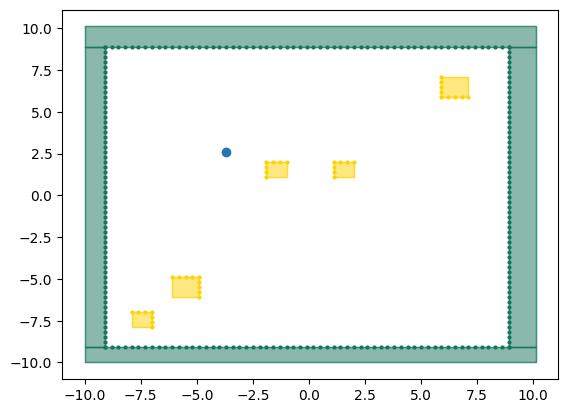

In [3]:
from bbtoolkit.utils.viz import plot_polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
position = 1000 # the position of the agent (visible area has dimensionality n_positions x 2)
env = compiler.environment
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

In [4]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = len(compiler.environment.objects)

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [5]:
# mtl_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/mtl_weights (5).pkl')
# tc_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/tc_weights (2).pkl')
# hd_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/hd_weights (2).pkl')
# pc_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/pc_weights (2).pkl')
# gc_map = GCMap.load('../../../Downloads/Telegram Desktop/gc_map (2).pkl')

# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_inserted_wall.pkl')
# tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_inserted_wall.pkl')
# hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights_inserted_wall.pkl')
# pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_inserted_wall.pkl')
# gc_map = GCMap.load('../data/weights/gc_map_inserted_wall.pkl')
mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_square.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_square.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_square.pkl')
gc_map = GCMap.load('../data/weights/gc_map_square.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [6]:
activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [7]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

In [8]:
red = '#b20000'
green = '#00b2b2'
cmap = generate_cmap(*[
    green,
    '#fff',
    red
])

In [9]:
%matplotlib qt

logging.getLogger('matplotlib').setLevel(logging.WARNING)

dt = .005

position = (7, -7)
direction = np.pi/2
attn_dist = 7.5

connectivity2use = connectivity.copy()
connectivity2use.h.to.h['phi'] = 4
# connectivity2use.pr.to.h['phi'] = 0
# connectivity2use.ovc.to.h['phi'] = 0
# connectivity2use.bvc.to.h['phi'] = 1000


cache = BBCache(
    connectivity2use,
    weights.copy(),
    k_ratio.copy(),
    activity.copy(),
    rates.copy(),
    tc_gen,
    compiler.environment,
    Grid2CartTransition(compiler.environment),
    DynamicParameters(dt, 'bottom-up'),
    EcodingParameters(),
    ClickParameters()
)

cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            MovementManager(
                5,
                np.pi*2,
                position,
                direction
            )
        ),
        MentalPositionCallback(),
        MentalMovementCallback(
            MovementManager(
                5,
                np.pi*2,
                position,
                direction
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        MentalMovementSchedulerCallback(),
        MentalTrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        AttentionCallback(
            DistanceAttention(7, dt, len(compiler.environment.objects), attn_dist)
        ),
        HDCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        ObjectWeightsUpdatingCallback(),
        PlottingCallback(
            [
                AloEnvPlotter(
                    attn_color=red
                ),
                EgoEnvPlotter(
                    attn_color=red
                ),
                MouseEventCallback(),
                TimerPlotter(),
                AgentPlotter(),
                TargetPlotter(
                    move_target_color=red
                ),
                TrajectoryPlotter(
                    target_color=red
                ),
                PWPlotter(cmap=cmap),
                BVCPlotter(cmap=cmap),
                oPWPlotter(cmap=cmap),
                OVCPlotter(cmap=cmap),
                HDPlotter(cmap=cmap),
                PCPlotter(cmap=cmap),
                oPRPlotter(
                    '#00b2b2',
                    '#b20000'
                ),
                ObjectRecallCallback(),
                PickedObjectPlotter(),
                DistanceAttentionPlotter(attn_dist, color=red),
                MentalAgentPlotter(),
                MentalTargetPlotter(),
                MentalTrajectoryPlotter()
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        ),
        FramesStoringCallback(5, '../tmp')
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None

KeyboardInterrupt: 

In [13]:
for _ in dynamics(True):
    print('out: ', _)

KeyboardInterrupt: 

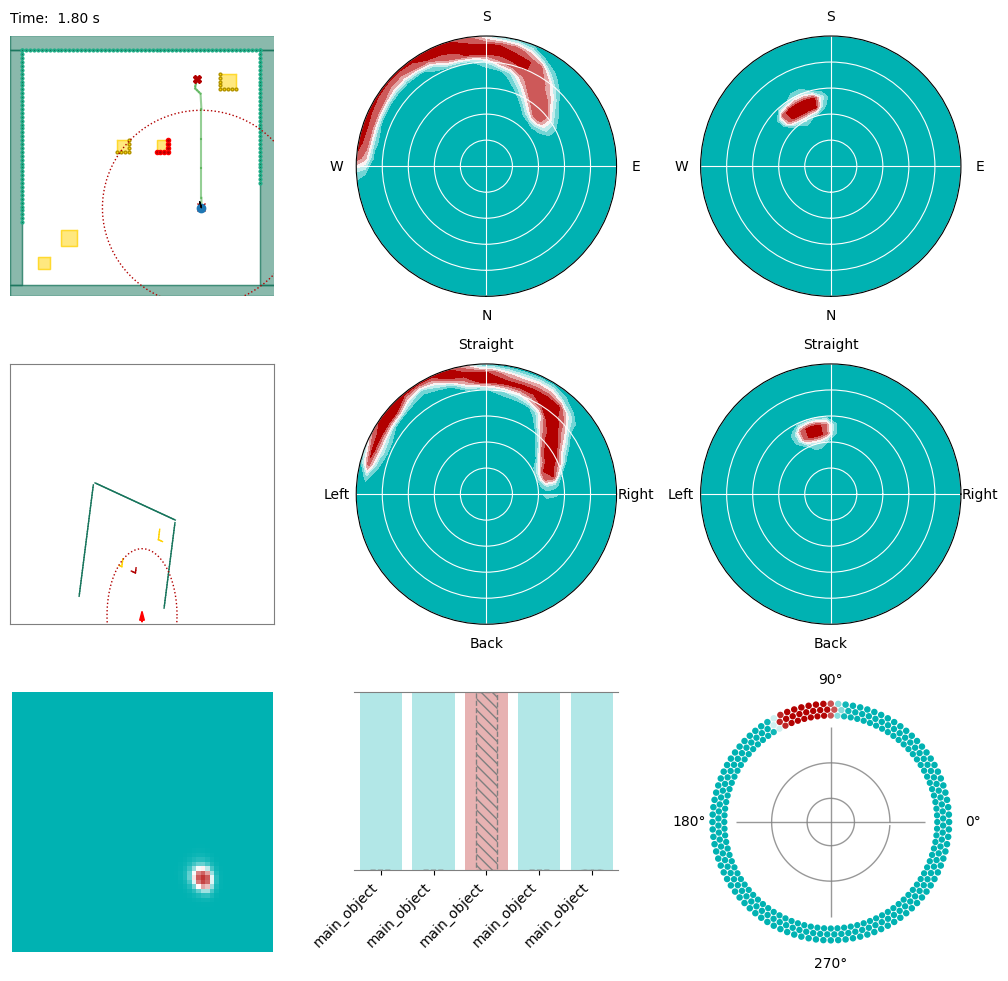

In [ ]:
%matplotlib inline
plt.show()

In [ ]:
import re
import cv2


def make_video_from_images(image_dir: str, save_path: str, fps: int = 30):
    """Creates and saves an MP4 video from a set of PNG images in a directory.

    This function reads PNG images from a specified directory, sorts them based on the numeric value in their filenames, and compiles them into an MP4 video at a specified frame rate.

    Args:
        image_dir (str): The directory containing the PNG images.
        save_path (str): The path where the MP4 video will be saved.
        fps (int, optional): Frames per second for the output video. Defaults to 30.

    Returns:
        None
    """
    # Get all PNG files in the directory
    images = [img for img in os.listdir(image_dir) if img.endswith(".png")]

    # Sort images by the frame number in their name
    images.sort(key=lambda x: int(re.findall(r"(\d+)", x)[-1]))


    # Read the first image to get the video dimensions
    frame = cv2.imread(os.path.join(image_dir, images[0]))
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
    out = cv2.VideoWriter(save_path, fourcc, fps, (width, height))

    for image in images:
        print(image, end='')
        frame = cv2.imread(os.path.join(image_dir, image))
        print(frame.shape)
        out.write(frame)  # Write out frame to video

    out.release()
    logging.info(f"Video saved to {save_path}")

In [ ]:
def rename_files(folder_path):
    # List all files in the folder and sort them to ensure correct ordering
    files = sorted([f for f in os.listdir(folder_path) if f.startswith('frame_') and f.endswith('.png')])
    
    # Start the new file numbering from 1
    start_number = 1
    
    for file in files:
        # Construct the new file name
        new_file_name = f'frame_{start_number}.png'
        start_number += 1
        
        # Construct the full old and new file paths
        old_file_path = os.path.join(folder_path, file)
        new_file_path = os.path.join(folder_path, new_file_name)
        
        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f'Renamed {file} to {new_file_name}')

# Example usage
folder_path = '../tmp copy'
rename_files(folder_path)

Renamed frame_4835.png to frame_1.png
Renamed frame_4840.png to frame_2.png
Renamed frame_4845.png to frame_3.png
Renamed frame_4850.png to frame_4.png
Renamed frame_4855.png to frame_5.png
Renamed frame_4860.png to frame_6.png
Renamed frame_4865.png to frame_7.png
Renamed frame_4870.png to frame_8.png
Renamed frame_4875.png to frame_9.png
Renamed frame_4880.png to frame_10.png
Renamed frame_4885.png to frame_11.png
Renamed frame_4890.png to frame_12.png
Renamed frame_4895.png to frame_13.png
Renamed frame_4900.png to frame_14.png
Renamed frame_4905.png to frame_15.png
Renamed frame_4910.png to frame_16.png
Renamed frame_4915.png to frame_17.png
Renamed frame_4920.png to frame_18.png
Renamed frame_4925.png to frame_19.png
Renamed frame_4930.png to frame_20.png
Renamed frame_4935.png to frame_21.png
Renamed frame_4940.png to frame_22.png
Renamed frame_4945.png to frame_23.png
Renamed frame_4950.png to frame_24.png
Renamed frame_4955.png to frame_25.png
Renamed frame_4960.png to frame_26

In [10]:
dynamics.save('../data/dynamics.pkl')

In [ ]:
%matplotlib qt
dynamics_pretrained = DynamicsManager.load('../data/dynamics.pkl')
for _ in dynamics_pretrained(True):
    print('out: ', _)

In [ ]:
# from bbtoolkit.utils.viz.video import make_video_from_images


image_directory = '../tmp/tmp2/'
video_save_path = '../data/videos/squared_room_mental_nav_3_lab_meeting.mp4'
make_video_from_images('../tmp copy', video_save_path, 4)

frame_1.png(960, 1015, 3)
frame_2.png(960, 1015, 3)
frame_3.png(960, 1015, 3)
frame_4.png(960, 1015, 3)
frame_5.png(960, 1015, 3)
frame_6.png(960, 1015, 3)
frame_7.png(960, 1015, 3)
frame_8.png(960, 1015, 3)
frame_9.png(960, 1015, 3)
frame_10.png(960, 1015, 3)
frame_11.png(960, 1015, 3)
frame_12.png(960, 1015, 3)
frame_13.png(960, 1015, 3)
frame_14.png(960, 1015, 3)
frame_15.png(960, 1015, 3)
frame_16.png(960, 1015, 3)
frame_17.png(960, 1015, 3)
frame_18.png(960, 1015, 3)
frame_19.png(960, 1015, 3)
frame_20.png(960, 1015, 3)
frame_21.png(960, 1015, 3)
frame_22.png(960, 1015, 3)
frame_23.png(960, 1015, 3)
frame_24.png(960, 1015, 3)
frame_25.png(960, 1015, 3)
frame_26.png(960, 1015, 3)
frame_27.png(960, 1015, 3)
frame_28.png(960, 1015, 3)
frame_29.png(960, 1015, 3)
frame_30.png(960, 1015, 3)
frame_31.png(960, 1015, 3)
frame_32.png(960, 1015, 3)
frame_33.png(960, 1015, 3)
frame_34.png(960, 1015, 3)
frame_35.png(960, 1015, 3)
frame_36.png(960, 1015, 3)
frame_37.png(960, 1015, 3)
frame_38.p

In [ ]:
from bbtoolkit.utils.datautils import remove_files_from_dir

image_directory = '../tmp copy'
remove_files_from_dir(image_directory)

In [ ]:
raise

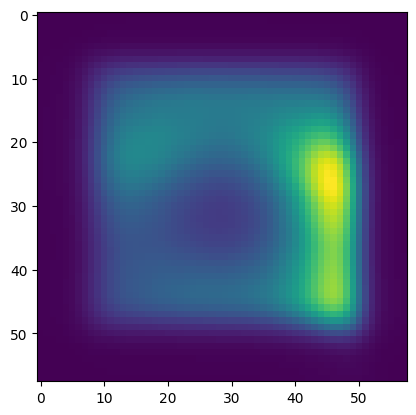

In [ ]:
%matplotlib inline
plt.imshow(np.reshape(cache.rates.h, cache.grid2cart.shape))

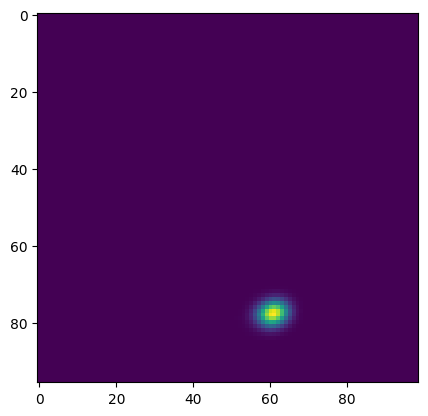

In [ ]:
plt.imshow(np.reshape(cache.weights.h.to.h@cache.rates.h, cache.grid2cart.shape))

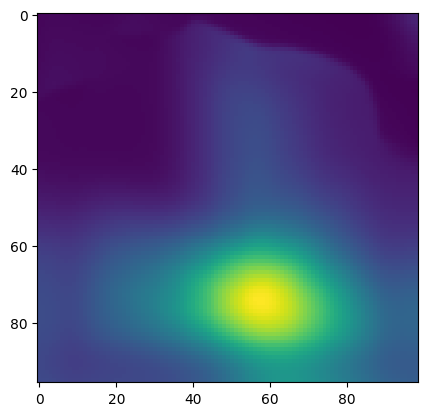

In [ ]:
plt.imshow(np.reshape(cache.weights.bvc.to.h@cache.rates.bvc, cache.grid2cart.shape))